## warehouse collision 해결하고 warehouse에 코드로 넣기

### deadend 해결을 heuristic map으로 구현한다면, navigate 설정을 조금 바꿔야 함 (어렵지 않음)

In [1]:
import os
import numpy as np
from crewai import Agent, Task, Crew
from environment import Environment
from openai import OpenAI
import copy
import configs
import pickle

os.environ["OPENAI_API_KEY"] = ""
client = OpenAI()

In [2]:
#negotiator를 구성하기 위한 union find 알고리즘

def find(parent, i):
    if parent[i] == i:
        return i
    else:
        return find(parent, parent[i])

def union(parent, rank, x, y):
    xroot = find(parent, x)
    yroot = find(parent, y)

    if xroot != yroot:
        if rank[xroot] < rank[yroot]:
            parent[xroot] = yroot
        elif rank[xroot] > rank[yroot]:
            parent[yroot] = xroot
        else:
            parent[yroot] = xroot
            rank[xroot] += 1

def merge_sets(lists):
    element_to_index = {}
    for i, subset in enumerate(lists):
        for element in subset:
            element_to_index[element] = i

    parent = [i for i in range(len(lists))]
    rank = [0] * len(lists)

    for subset in lists:
        first_element = subset[0]
        for element in subset[1:]:
            union(parent, rank, find(parent, element_to_index[first_element]), find(parent, element_to_index[element]))

    new_sets = {}
    for element in element_to_index:
        root = find(parent, element_to_index[element])
        if root not in new_sets:
            new_sets[root] = set()
        new_sets[root].add(element)

    return [list(s) for s in new_sets.values()]

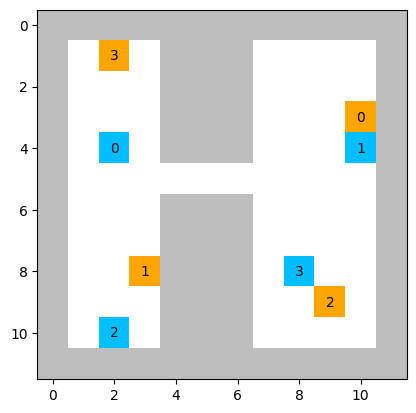

In [3]:
directiondict = {
    'Stay': 0, 'North': 1, 'South': 2, 'West': 3, 'East': 4, 'Stay.': 0, 'North.': 1, 'South.': 2, 'West.': 3, 'East.': 4 
}

# Toy example 만들기(환경, 처음 위치, 목적지)
toy = (np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1], [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1], [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1], [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1], [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1], [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1], [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1], [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), np.array([[4, 2], [4, 10], [10, 2], [8, 8]]), np.array([[3, 10], [8, 3], [9, 9], [1, 2]]))
num_agents = len(toy[1])
map_width = len(toy[0][0]) - 1

env = Environment()
env.load(toy[0], toy[1], toy[2])
env.render()

In [4]:
class PathFindingAgents:
  def path_finder(self, agent_number):
    return Agent(
      role='Path finder',
      goal='Start at the start point and reach the end point without crashing into a wall.',
      backstory=f"""You are a veteran adventurer with a great sense of direction.
      You understand which direction you need to move to get from where you are to where you want to go.
      Your agent number is {agent_number}.
      """,
      verbose=True
    )
    
  def negotiator(self):
    return Agent(
      role='Negotiator',
      goal="""Determine whether the deadlocked agents would collide with each other if they took their original planned moves, and if so, stop all but the agent with the largest number.""",
      backstory="""You're a veteran overseer, and you've been called in to resolve the deadlock, as each agent is in the other's line of sight.
      """,
      verbose=True,
    )
	
class PathFindingTasks():
  def path_finding(self, agent, x, y, x_finish, y_finish, east, west, north, south, last_action, coordinates, agent_FOV):
    return Task(
      description=(
        f"""
        Your current coordinates are ({x},{y}) and your destination is ({x_finish},{y_finish}).
        East and west in the coordinates correspond to the x axis.
        South and north in the coordinates correspond to the y axis.
        You can only move east, west, south and north or stay.
        So, your answer will be {{East}}, {{West}}, {{South}}, {{North}}, or {{Stay}}.
        You can only make one move at a time.
        Below is your field of view, the centre is your current position, 0 is unobstructed space, and 1 is obstructed space.
        {agent_FOV}
        {east}
        {west}
        {south}
        {north}
        {last_action}
        Below is a list of the coordinates you visited.
        {coordinates}
        If you keep hovering over coordinates you've already visited, you're in a dead end, and it is recommended that you start exploring again as far away from the hovering coordinates as possible.
        This map consists of two rooms, with a passageway in the middle.
        You can use your vision to find the passageway to the opposite room.
        Which direction do you move next?

        Answer in one word only: {{DIRECTION or ACTION}}
        """
      ),
      expected_output='Direction or action',
      agent=agent
    )
    
  def negotiate(self, agent):
    return Task(
      description=(
        f"""
        Determine whether the deadlocked agents would collide with each other if they took their original planned moves, and if so, stop all but the agent with the largest number.
        The planned moves of each agent represent the previous outcomes.
        """
      ),
      expected_output='Direction of the agents',
      agent=agent
    )
  
  def give_way(self, agent, east, west, north, south, direction):
    return Task(
      description=(
        f"""
        You MUST avoid collisions with prior path finder.
        You can only move east, west, south and north or stay.
        So, your answer will be {{East}}, {{West}}, {{South}}, {{North}}, or {{Stay}}.
        You can only make one move at a time.
        {east}
        {west}
        {south}
        {north}
        To the {direction} of you is prior path finder.
        Which direction do you move next?
        I highly recommend going to the 90-degree turn rather than the other side of the pathfinder, but you can ignore this instruction depending on your situation.
        Answer in one word only: {{DIRECTION or ACTION}}
        """
      ),
      expected_output='Direction or action',
      agent=agent
    )

agents = PathFindingAgents()
tasks = PathFindingTasks()

agents_set = [agents.path_finder(i) for i in range(num_agents)]
negotiator = agents.negotiator()

In [5]:
#에이전트들의 지난번 액션들과 좌표
action_list = [[] for _ in range(num_agents)]
coordinate_list = [[] for _ in range(num_agents)]



> Entering new CrewAgentExecutor chain...


2024-06-18 18:55:35,476 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on the description, all directions seem to have a path. Also, my destination (10,8) is more towards the east and a little bit north from my current position (2,7). Therefore, it makes sense to move towards the east. 

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 18:55:46,364 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position and the fact that East is blocked by a wall, I have three options. 
I can move West, North, or South. 
Since my destination coordinates are (3,3), which is to the West and South from my current position, it would be logical to move either West or South. 
However, I need to consider the map's layout with two rooms and a passageway in the middle. 
So, it's important to find the passageway to the other room. 
As I haven't visited any other coordinates yet, I don't have to worry about returning to a previously visited coordinate. 
So, my decision should be based on getting closer to the destination and finding the passageway. 

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 18:55:50,170 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on my current coordinates and field of view, it appears that my path to the east, west, and north is unobstructed, while the south is blocked by a wall. Given that my destination of (9,2) is to the east of my current position, logically, the best direction to take would be east.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...
Looking at my current coordinates (8,3) and the destination (2,10), I can see that I need to move North and West. However, I have to make only one move at a time. Since there is a path in all directions, I need to make a decision on which direction to go first. I will make a move towards the North to get closer to the destination.

Final Answer: North

> Finished chain.


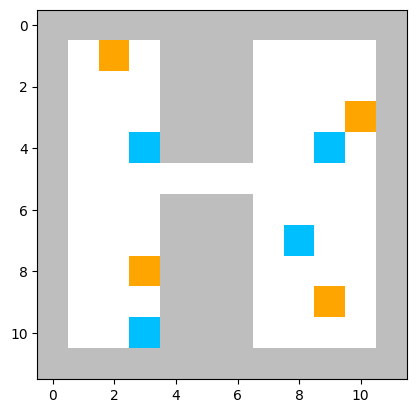

2024-06-18 18:55:55,755 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 18:56:03,346 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Looking at the layout of the map and my current position, I can see that the east is blocked by a wall. I came from the west, and backtracking generally isn't beneficial unless there are no other options. Both the south and north are open, so I have to decide between these two directions. The goal is to reach coordinates (10,8). Currently, I am at (3,7). Moving north takes me further from the goal on the y-axis, but moving south brings me closer to the goal on the y-axis. Hence, considering the goal coordinates, the optimal direction to move would be south.

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 18:56:09,276 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given my current coordinates (9,7) and the target coordinates (3,3), I need to move both westward and southward. Since I just came from the east, moving back east would lead me to revisit coordinates. Therefore, a good strategy would be to first move south to avoid the possibility of entering a cycle. The path to the south is unobstructed, so it is a feasible move. 

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 18:56:15,116 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given that I am currently at (3,1) and my destination is (9,2), and considering that east and south are blocked by walls, I cannot move in those directions. Since I came from the west, it would not be beneficial to go back there. Therefore, the only viable option for me to move forward in reaching my destination is to go north.

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering my current position and the destination, I need to move northwards. However, I also need to avoid revisiting the coordinates I've already been to. As the field of view shows that the path to the north is unobstructed, and I came from the south, I should move North.

Final Answer: North

> Finished chain.


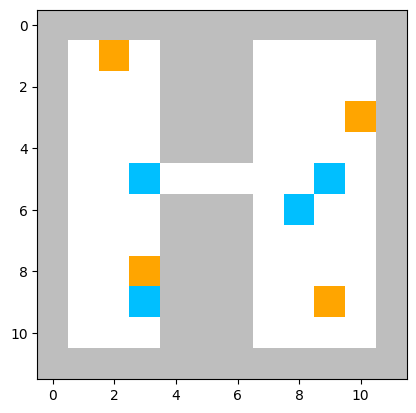

2024-06-18 18:56:19,520 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 18:56:25,604 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering the current coordinates, the destination, the field of view, and the already visited coordinates, it seems the best move would be to go East. This is because the destination is more towards the East from the current position and the path in that direction is clear. Going South, North, or West would either lead to already visited coordinates or to a dead end. 

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 18:56:28,950 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on the current position, the map layout and the directions available, the best move would be to head north to avoid the wall on the east and to not backtrack the path already taken.

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 18:56:35,351 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position (9,6) and destination (3,3), it's clear that I need to move in a south-west direction. However, I can only move in one cardinal direction at a time. I came from the north, and I don't want to backtrack. Looking at my field of view, all directions are clear. To get closer to my destination, I should move west first as it will bring me closer to my goal along the x-axis. After moving west, I can re-evaluate the situation and decide on the next move.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 18:56:39,679 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering the current position, the destination, and the open paths in each direction, the best direction to move next would be North. This is because the destination (2,10) is North of the current position (8,5).

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering the information provided, I must avoid colliding with the prior pathfinder located to my southwest. To ensure I do not move into the pathfinder's space, I should move in a direction that is not towards it. Therefore, considering the recommendation of making a 90-degree turn, I should move either towards the east or north.

Final Answer: East

> Finished chain.


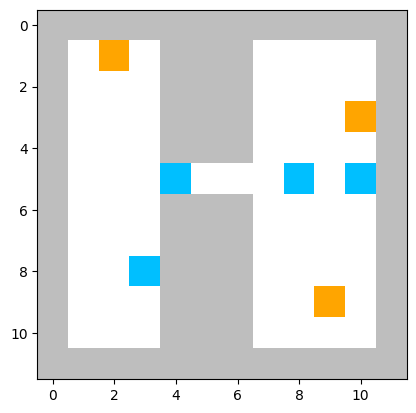

2024-06-18 18:56:44,626 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 18:56:49,386 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering the current coordinates and the destination, I have to move towards the east to get closer to my goal. The directions indicate that the east and west paths are open. Since I came from the west, I need to move towards the east to explore new coordinates and find the way towards my destination.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 18:56:58,008 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Looking at the field of view, I can see that the path to the east is blocked by a wall. The path to the west, south, and north are open. Since I came from the south and my destination (9,2) is to the east, going back south or continuing east doesn't seem to be an option. The coordinates visited also show that I have been moving in a loop between (2,1), (3,1), (3,2), and (3,3). So, moving west or north could potentially help me break this cycle and possibly find the passageway to the opposite room where my destination is.

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 18:57:04,775 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given my current position (10,6), the blocked path to the east, and the available paths to the west, north, and south, I can determine my next move. Looking at the coordinates I've already visited, I can see that I've been hovering around the same area. Therefore, it's likely I'm in a dead end. It's recommended to start exploring as far away from these coordinates as possible. My goal is to reach (3,3), and currently, I am to the east and north of my destination. My best option would be to move west or south. However, moving south will bring me closer to my destination. 

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering my current position and the destination, I need to head northwards. However, I have previously visited the south and I should avoid revisiting the coordinates. I can see that all paths around me are unobstructed, so I am not at a dead end. I will proceed to the north, which seems to be the correct direction towards the desti

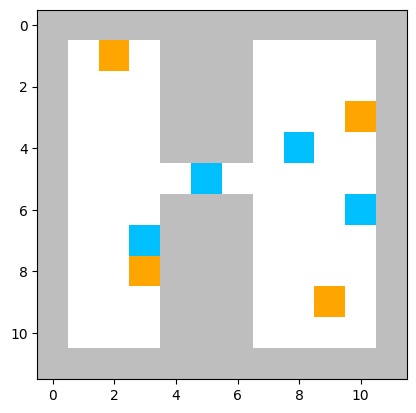

2024-06-18 18:57:10,610 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 18:57:14,714 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given the current coordinates and the state of the surrounding environment, it seems like the best course of action is to move East. This is because the path to the East is clear, while the paths to the North and South are blocked by walls. Additionally, I came from the West, which indicates that the direction towards the destination is likely East.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 18:57:21,216 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on the current position and the layout of the map, it's clear that moving east is not an option due to the wall. Since the goal is to reach the coordinate (9,2) which is eastward and southward from the current position, the best option would be to move southward. This is because moving north or west would take me further away from the destination. Additionally, I've already visited the coordinates to the south, so it's safe to assume that there's no obstacle in that direction. Therefore, my next move should be to go south.

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 18:57:26,039 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Looking at the map, my east is blocked by a wall and I came from the north, so going back north won't be productive. I can either go west or south. Since I have visited the coordinates to the west before, going there might lead me into a dead end. So, the best option would be to head south. 

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...
Given my current position at (8,7), and my target destination at (2,10), I need to move generally in a North and West direction. However, I must consider the obstructions in my path. The fact that there is unobstructed space to my East, West, North, and South gives me multiple choices. 

Considering my previous path, I came from the South and it seems I've been moving generally North. Since I have not visited the same coordinates repeatedly, I am not in a dead end. However, I should remember the advice to start exploring as far away as possible from hovering coordinates when I find myself in a dead end.

Given the l

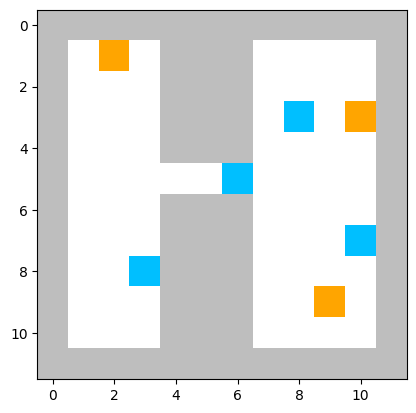

2024-06-18 18:57:40,342 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 18:57:47,978 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Looking at the map, I can see that the east direction is blocked by a wall. I arrived from the north. The south and west directions are pathways. My goal is to reach the point (3,3) from my current position (10,4). Considering that the destination point is to the south and west of my current position, I should head in the south or west direction. Since I came from the north, going south would be a better choice.

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 18:57:52,194 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since my east is blocked and I just came from the north, I can either go west or south. However, looking at my visited coordinates, it seems like I've been hovering around the same area for a while. Therefore, it might be beneficial to move south, towards a new area. 

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 18:57:57,497 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given my current position and the layout of the map, it is clear that my next move should be East. This is because both to the South and North are blocked by walls, and since I just came from the West, the only viable option is to move East. This would also put me closer to my destination, as I am currently at (6,6) and need to reach (10,8).

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...
Looking at the field of view, it seems there are open paths in all directions. However, since the destination (2,10) is to the north and west of the current location (8,8), it would make sense to head in one of those directions. Since I came from the south, I'll avoid retracing my steps, and there is a wall to the west, so going north seems like the best option. 

Final Answer: North.

> Finished chain.


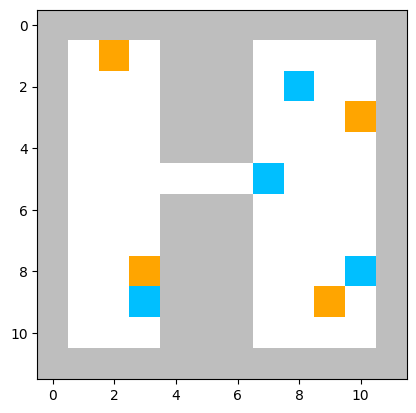

2024-06-18 18:58:03,098 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 18:58:07,391 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Looking at the map, there is a clear path to the east, which hasn't been explored. Since I came from the west and I am trying to move to the coordinates (10,8), moving east will also get me closer to my destination. Therefore, I should move to the east.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 18:58:12,362 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Looking at the map, it's clear that going east is not an option due to the wall. I just came from the north, where I had been circling without making progress toward the destination, so it would not be wise to go back there. The south and west directions are clear and are part of the coordinates I have not visited yet. The destination is to the west, so that would be the logical direction to head toward.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 18:58:16,639 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


After evaluating my current position and the surrounding environment, it's clear that moving east is not an option due to the obstruction. Since I came from the north and moving south could lead me back to previously visited coordinates, it would be best to move west as it's the only other unblocked direction. 

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Looking at the map, I see that all directions are open to me. However, I am aware that I am moving away from my destination. My current position is (8,9) and I need to get to (2,10). This means I need to move west. But I also need to consider that I may fall into a dead end if I keep hovering over coordinates I've already visited. I have visited the coordinates (8,3) to (8,9) which indicates that I have been moving mostly in a north-south direction. To avoid a potential dead end and to move closer to my destination, my best course of action would be to move west. 

Final Answer: West

> Finished c

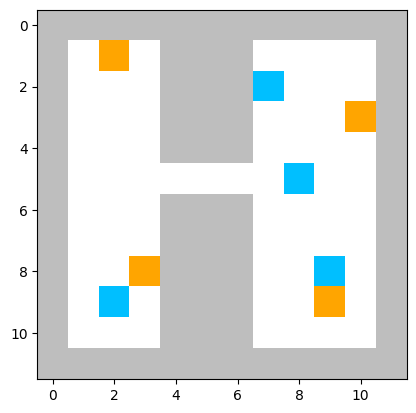

2024-06-18 18:58:25,711 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 18:58:33,165 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Looking at my field of view and my current position, it seems I have an open path in all directions. I came from the west, so it might be best to avoid going back that way. My destination is (10,8) which is to the north-east from my current position (8,6). Therefore, the best direction to move would be either east or north. However, considering that I want to avoid hovering over coordinates I've already visited, moving north could potentially lead me back to the path I've already explored. Thus, moving east seems to be the best option.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 18:58:39,198 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on the map, it seems like going west would take me back to the coordinates I've already visited. So it wouldn't be wise to go back that way. Going east is blocked by the wall. Hence, the best option suggested by my sense of direction would be to go either north or south to find the passageway to the opposite room. Since I came from east, it might be better to go north to explore new areas. 

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 18:58:44,089 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given the information, it seems I can move in any direction, but since I came from the east and I'm trying to avoid backtracking, it would be best to avoid going there again. Also, my destination is to the east, at (9,2) from my current position (2,2). Therefore, it would be best for me to move in that direction.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...
Given my current position and the orientation of the walls around me, it appears I need to move North to reach my destination. Moving East or South would only take me further away from my destination, and West is blocked. Moreover, as I came from the East, moving North will help me explore new areas and possibly find the passageway to the other room. 

Final Answer: North

> Finished chain.


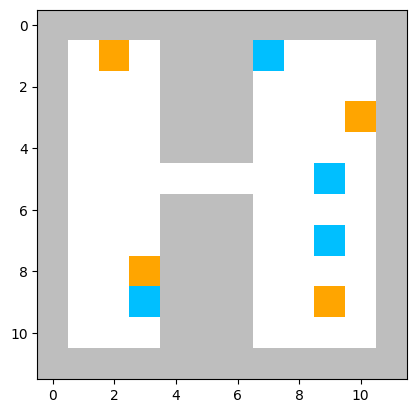

2024-06-18 18:58:49,364 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 18:58:54,795 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Looking at my field of view, I see that my east is blocked by a wall. I also see that I've visited the coordinates to my west and south before, which means returning there could lead to me hovering over the same coordinates. I came from the west and the path to my north is unobstructed and unvisited. Thus, my best option is to move north.

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 18:58:58,646 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Looking at my current position and the given map, I see that I cannot move west or north as they are blocked by walls. I came from the south, and I don't want to backtrack. The only unexplored and accessible direction left is east. 

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 18:59:03,627 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on my current coordinates (9,6) and my destination (10,8), I need to move north to get closer to my goal. The field of view shows that there are no obstructions in the north direction. Since I have not visited this coordinate before and it is in the direction of my target, moving north is the best option. 

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...
Given my current coordinates are (9,4) and my destination is (3,3), I need to move south-west. However, I can only move in one direction at a time. I came from the south, and considering the field of view, there is an obstructed space to the east. Considering I need to avoid visiting the same coordinates, I should move west to start exploring again as far away from the hovering coordinates as possible.

Final Answer: West

> Finished chain.


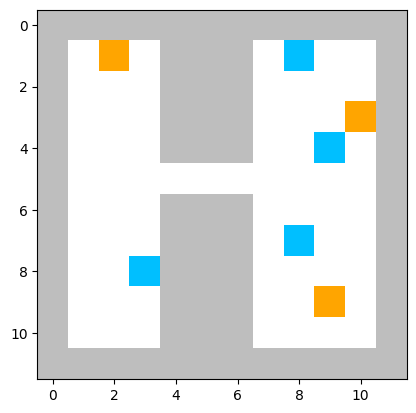

2024-06-18 18:59:10,922 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 18:59:16,045 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering the current position and destination, the shortest path would be to move East and then North. However, as there is an obstruction to the East, I need to find another route. I came from the South, and there are no obstructions to the North, West and South. Since I aim to avoid revisiting coordinates and I have not yet moved North from this position, the best direction to proceed would be North.

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 18:59:22,210 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering the current coordinates, the destination, and the path I have taken so far, it seems I need to move towards the west to get closer to my destination. This is because the x-coordinate of the destination (3) is less than my current x-coordinate (8), indicating I need to move west. There are no obstructions to the west according to the field of view. Therefore, my next move should be towards the west.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 18:59:28,175 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Looking at the given field of view and the coordinates I have visited, it seems that going back to the south will lead me to the same coordinates I have already visited. The east is blocked by a wall and I came from the south. Therefore, the best option would be to move to the west or north. Since my goal is to reach (9,2) which is further to the east, it would be more strategic to move north first to find a way around the wall to the east.

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering the current situation, my initial position, and the final destination, it seems the best choice would be to move West. Moving East or South would only take me further away from my destination, and North is blocked. Also, I came from the West, which means there is no obstruction in that direction.

Final Answer: West

> Finished chain.


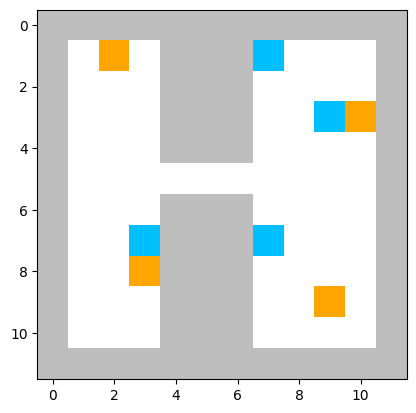

2024-06-18 18:59:33,294 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 18:59:40,048 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position (7,4), my destination (3,3), and the fact that I came from the east, my best option would be to move west. However, my west is blocked by a wall, so I cannot proceed in that direction. Given that I can only make one move at a time and I need to start exploring again as far away from the hovering coordinates as possible, my best choice would be to move north, which is unobstructed.

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 18:59:46,326 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given my current coordinates (3,4), the destination (9,2), and the field of view, I can see that my path to the east is blocked. I've also been hovering over the same coordinates, suggesting that I'm in a dead end. I came from the south, and the map consists of two rooms with a passageway in the middle. The best course of action would be to move west and then north, trying to find a way around the obstacle that is blocking my path east.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 18:59:50,659 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on my current coordinates (9,8) and my destination coordinates (10,8), I need to move East to reach my destination. There are no obstructions according to the field of view provided, and considering my previous movements, moving East will not cause me to revisit any previously visited coordinates. Therefore, the best step to take is to move East.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering my current position and the field of view, the south is open and leads towards the destination. Since I came from the east, moving back there would not make sense. Moving north is not an option as it is blocked by a wall. Also, going west is not possible due to a wall. Therefore, the best option is to move south.

Final Answer: South

> Finished chain.


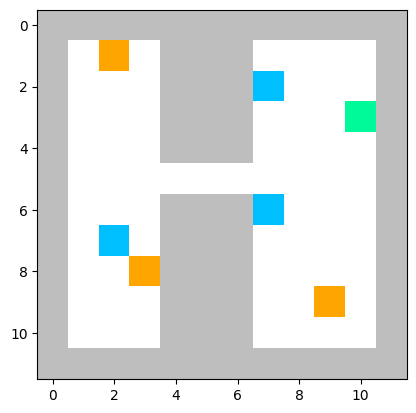

2024-06-18 18:59:55,710 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 18:59:59,320 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since I came from the west and the east is blocked by a wall, I should try moving to the north or south. However, since I'm already at the destination coordinate (10,8), it's best to remain where I am.

Final Answer: Stay

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 19:00:06,258 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on the current coordinates, I am situated at a position where there are paths to my east, north, and south. Considering the destination coordinates, I need to move southward and westward. However, since the west is blocked by a wall, my best option would be to initially move south, and then hopefully move west when the path allows. My past coordinates also indicate that I should avoid moving northwards to prevent hovering over previously visited coordinates. 

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 19:00:13,188 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Looking at the map, all directions seem unobstructed, but I've already visited the coordinates to the east and west, and there seems to be a dead end. The coordinates to the north and south are yet unexplored and seem to be a better choice to proceed further. Since I came from the east, I should avoid going back in that direction. Moving north could possibly lead me to the other room through the passageway. 

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...
Based on the provided information, I am currently at coordinates (7,9) and I need to get to (2,10). Looking at the map, my path to the east and south is clear, but the west is blocked. Also, I have previously visited the north. My goal is to reach the destination with minimum backtracking. Considering my current position and the destination, the best option would be to move south as it would take me towards the lower coordinates which aligns with my destination.

Final Answer: South

> Finished chai

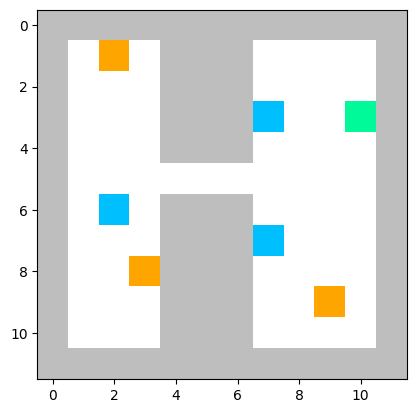

2024-06-18 19:00:20,111 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 19:00:23,454 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since I am already at my destination coordinates (10,8), there is no need to move further. Therefore, my next action would be to stay.

Final Answer: Stay

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 19:00:29,636 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering the current position and field of view, the path to the east and south seems unobstructed while the west is blocked. North is also an option but it's the direction I came from. My goal is to reach (3,3) which is at the south-west of my current position (7,4). Given I can't move west due to the obstruction, I should move south to get closer to the destination.

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 19:00:40,085 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on the information given, my current position is (2,5) and the destination I'm aiming for is (9,2). The field view indicates that there are paths in all directions: east, west, north, and south. However, I've already visited a number of coordinates which suggests that I'm in a dead end. The map consists of two rooms, with a passageway in the middle, which I need to find to reach my destination. Because I came from the south, I should avoid going back in that direction. Therefore, my next best decision would be to move east, towards the unexplored area.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering my current position and the surrounding terrain, I need to move to the east where there's an unobstructed path. Moving to the west is not possible as it is blocked. Going north or south would lead me back to coordinates I've already visited, which suggests a dead end. Hence, the most logical move would be to go east.

Final Answer: East.


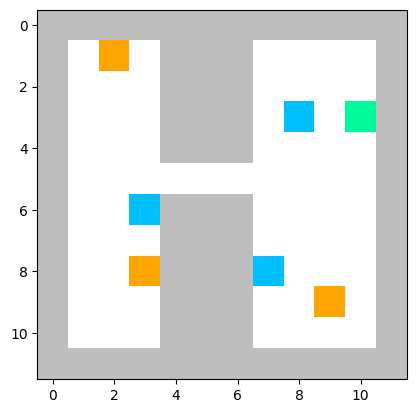

2024-06-18 19:00:46,366 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 19:00:52,677 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on the information provided, my current position is (7,3) and the destination is (3,3). The field of view shows a clear path to the east, but the west is blocked. I also have a history of backtracking, which indicates I might have been in a dead end. The room layout suggests there's a passageway somewhere which I can use to reach the other room. I should try to find that passageway.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 19:01:00,283 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on the information provided, my current position is blocked to the east by a wall. Since I came from the west, moving back is not a good idea as I might end up in a loop. My current coordinates show that I have already explored the south, as the coordinates [3,2], [3,3] and [3,4] have been visited. I still have the north direction to explore from my current position, and since there is an unobstructed path in the north direction, it would be a wise move to proceed to the north.

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 19:01:03,216 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since I am already at the target coordinates (10,8) and there is no need to move any further, I should stay in my current position. 

Final Answer: Stay.

> Finished chain.


> Entering new CrewAgentExecutor chain...
Looking at the field of view, I can see that all directions are open for movement. However, I need to get to the coordinates (2,10) from my current position at (8,8). Considering that I came from the west, and I don't want to hover over coordinates I've already visited, it is logical to move north. As moving north will bring me closer to the y-coordinate of my destination, and it also offers the chance to explore new areas.

Final Answer:
North

> Finished chain.


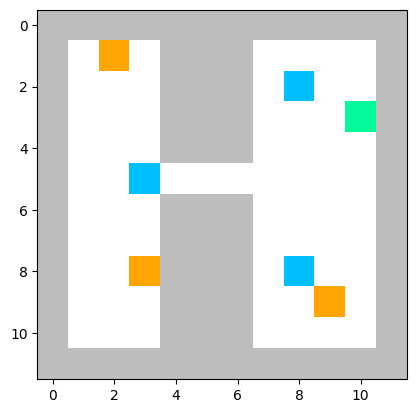

2024-06-18 19:01:10,791 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 19:01:16,399 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on the current coordinates (8,3), I need to move to (3,3). The destination lies to the west of my current position. My field of view suggests that there is an unobstructed path to the west. Also, considering my past movements, moving westward seems to be a logical choice as I do not seem to be in a dead end. Therefore, I should move west.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 19:01:25,359 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Looking at my current position (3,6), and considering my destination is at (9,2), it seems I need to move in the direction that gets me closer to my destination. I am currently in the middle of a room surrounded by a wall to my North and South, but I have clear paths to my East and West. Since the x-coordinate of my destination is greater than my current x-coordinate, it would be wise to move East, as this will bring me closer to my destination. 

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 19:01:27,125 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


I now can give a great answer.

Final Answer:
Stay

> Finished chain.


> Entering new CrewAgentExecutor chain...
Given my current position (8,9), and considering that my destination is at (2,10), I need to move towards the west to decrease my x-coordinate. However, I also need to be careful about the walls and the path I have already taken. Comparing my current position with the list of coordinates I have visited, it appears that I have been moving in circles. It seems I am in a dead-end, and I need to start exploring again as far away from these coordinates as possible.

Final Answer: West

> Finished chain.


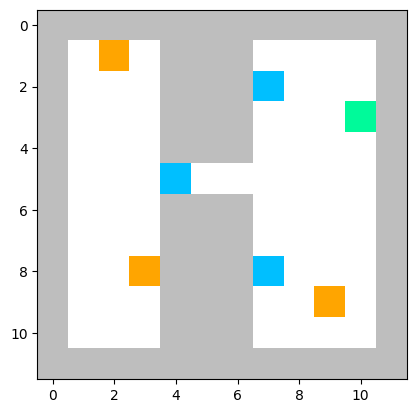

2024-06-18 19:01:35,642 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 19:01:39,120 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering the current coordinates are the same as the destination coordinates and the field of view confirms that I am not in a blocked or dangerous location, I am already at the destination. Therefore, there is no need to move further.

Final Answer: Stay

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 19:01:47,267 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on the map and my current position, moving west is not an option as it is blocked by a wall. Moving east would take me back to a place I've already visited which is not recommended. Therefore, the best options are to either go north or south. Since my destination is (3,3) and I'm currently at (7,3), moving south would take me further away from my destination. Therefore, the best direction to move next is north.

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 19:01:51,194 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering that I am currently in a position where the south and north directions are blocked by walls, and I came from the west, I should proceed through the free path to the east. This direction is also towards my destination coordinates (9,2). 

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...
Given that my current position is (7,9) and my goal is (2,10), I need to move towards the west in order to get closer to the destination. However, my west is blocked by a wall. Also, considering the coordinates I have visited, it seems I am hovering around the same position, indicating a dead end.

The map consists of two rooms with a passageway in the middle. The east and south paths are unobstructed and since I came from east, it would be a wise decision to head south to explore new areas and find the passageway to the opposite room. 

Final Answer: South

> Finished chain.


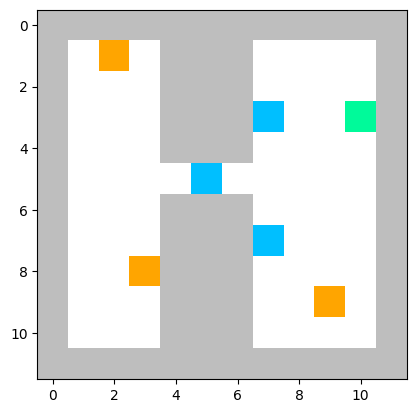

2024-06-18 19:02:01,757 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 19:02:04,440 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since I am already at my destination coordinates (10,8), there is no need for me to move. I have reached my goal. 

Final Answer: Stay

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 19:02:10,815 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering the map layout, my current position, and the destination, it seems the best option is to head South to avoid the wall to the West and not to backtrack North. I have already visited several coordinates and do not want to hover over them again as it likely leads to a dead-end. This decision is also based on the information that there are two rooms with a passageway in the middle. Moving South could potentially lead me to the passageway that takes me to the opposite room, bringing me closer to the destination (3,3).

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 19:02:18,842 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering that my current position is (5,6), and my destination is (9,2), I need to first move towards the east to avoid the walls in the north and the south. Moreover, since the map consists of two rooms with a passageway in the middle, I should aim to find this passageway. Looking at the coordinates I've already visited, it's clear that I've been hovering in the same area, suggesting that I'm in a dead end. Therefore, moving east should hopefully allow me to find the passage to the opposite room and, ultimately, my destination.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...
Given the current situation, it's clear that moving west is not an option due to the obstruction. My current coordinates are (7,8), and the destination is (2,10). I am closer to the destination in terms of the y-axis, but I need to move to the left (west) on the x-axis. Since that is not possible at the moment, I need to find an alternative route. Moving south could potentiall

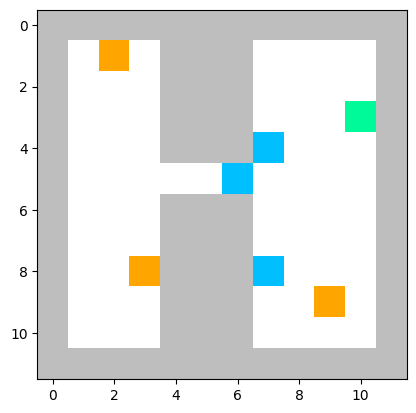

2024-06-18 19:02:29,056 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 19:02:31,491 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given my current coordinates match with my destination coordinates, I don't need to move. I have reached my goal. 

Final Answer: Stay

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 19:02:40,086 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given my current position and destination, I need to move westward to reach the destination. However, the west is blocked by a wall according to the field of view provided. The only unobstructed paths available to me are east, south, and north. Since I came from the north, I should avoid going back that way. Going south would take me further away from my destination. Therefore, the best course of action would be to move east and then try to find a way around the wall to head west towards my destination.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 19:02:44,898 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on my current position (6,6) and the available paths to the east and west, my goal is to reach the destination (9,2). Since I cannot go south or north due to obstructions and I have already come from the west, I should move east. This direction will lead me closer to my destination.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...
Based on my current coordinates (7,7) and the destination (2,10), I'll need to move north or west to get closer to my destination. However, the west is blocked by a wall. Looking at the coordinates I've already visited, I've repeatedly hovered over the same coordinates, suggesting I'm in a dead end. Therefore, I need to find a new path. To the east and south of my current position are unobstructed paths. But moving south or east would take me further from my destination. Since I can't move west and I've been advised to start exploring again as far away from the hovering coordinates as possible, the best possible move wo

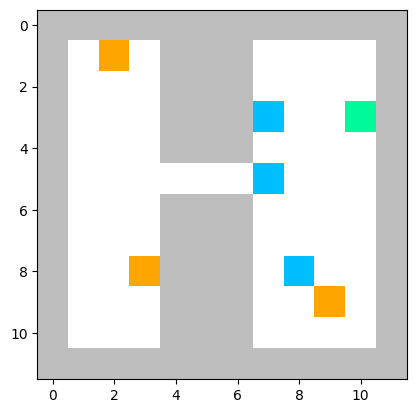

2024-06-18 19:02:56,336 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 19:02:58,468 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since my current position is the same as my destination, I don't need to move anywhere.

Final Answer: Stay.

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 19:03:05,137 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Looking at my current coordinates (8,3), and my destination (3,3), it's clear I need to head west. Additionally, it seems there is a clear path for me to travel in that direction. This is also in line with the fact that I need to get as far away from the coordinates I've been hovering over, as I appear to be in a dead end. Therefore, it makes the most sense to head west next.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 19:03:10,517 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given that my current position is (7,6) and my destination is (9,2), and the fact that I came from the west, I need to move eastwards. From my field of view, my east is unobstructed and could lead me closer to the destination. Also, this will prevent me from hovering over coordinates I've already visited.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering my current position and the destination, I need to move northward. However, the previous path indicates that I was in a loop, hovering over coordinates I've already visited. I need to find the passageway to the opposite room. Given that east and south are the only unvisited paths, and I came from the south, it would be best to explore eastward.

Final Answer: East.

> Finished chain.


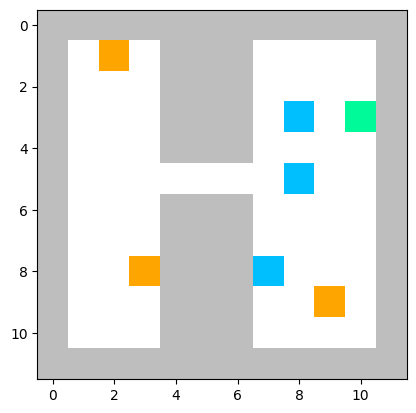

2024-06-18 19:03:16,320 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 19:03:23,915 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on the field of view, I am surrounded by walls on the north and west. The path to the east is where I came from and I have already visited those coordinates. However, to the south, there is an unobstructed path. Given that I need to move in the opposite direction of where I came from, and my destination is (3,3) which is to the west, I should head south to find a passageway that could lead me towards the west. 

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 19:03:26,520 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on the information given, I am currently at my destination coordinates (10,8). Therefore, there is no need to move in any direction.

Final Answer: Stay

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 19:03:30,763 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering the current position and the destination, the best course of action would be to move South. This is because the destination (9,2) is to the South-East of the current position (8,6). The path to the East is blocked, hence, moving South would be the best direction to take.

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...
Based on my current coordinates (8,8) and the destination (2,10), I need to move North and West. However, given the information about the map structure and my past movements, it appears that my current position may be in a loop. Therefore, I need to move out of the loop and try to find the passageway to the other room. Considering my current field of view and the fact that I came from the West, the best immediate move would be to travel East.

Final Answer: East

> Finished chain.


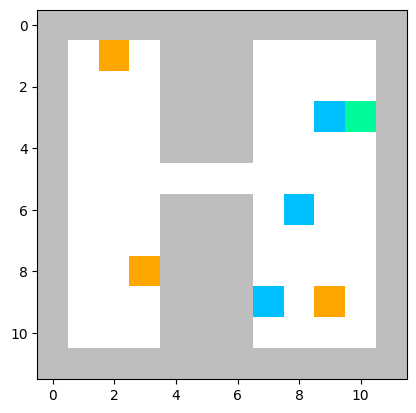

2024-06-18 19:03:38,576 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 19:03:46,647 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on my current coordinates (7,2), destination coordinates (3,3), and my field of view, it appears that the only available directions for me to move are either east, south or north. Since my destination lies more to the west and north of my current position, and the west is currently blocked, moving south would take me further away from my destination. Also, since I came from the north, it would be logical for me to explore the east. Therefore, I believe the best move would be to go towards the east and hopefully find a passage to the north that will lead me closer to my destination.

Final Answer: East.

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 19:03:50,925 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Looking at the field of view and the coordinates I've already visited, it seems I'm in the upper room and need to move to the lower room to reach my destination. The passageway is likely to the south, given the layout of the map and the coordinates I've visited. 

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 19:03:53,707 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Looking at the current coordinates, it's clear that I've already reached my destination (10,8). Therefore, I don't need to move further. 

Final Answer: Stay

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering the map layout and the fact that I came from the west, it seems logical to move North. I need to get to the coordinates (2,10) and I'm currently at (9,8), moving North will get me closer to my destination. Despite the fact that I can also move East, West, and South, the North path seems like the most direct route towards my destination. 

Final Answer: North.

> Finished chain.


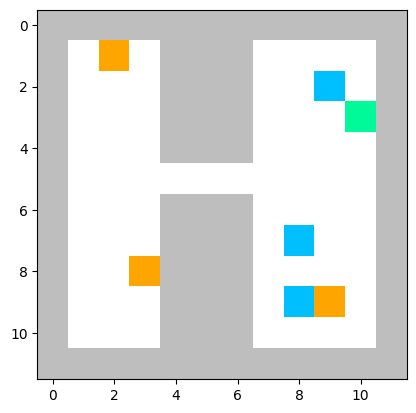

2024-06-18 19:03:59,707 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 19:04:02,852 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


I am currently at my destination point (10,8) and my task is to reach (10,8). This means I have already achieved my goal and don't need to move anywhere. 

Final Answer: Stay

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 19:04:08,041 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given my current position, the destination, and considering the previous coordinates I visited, I need to start moving north towards the other room. I came from the south, and the path to the north is unobstructed, which means I can move in that direction. I must avoid moving to the same coordinates I visited before to prevent hovering in the same place and not reaching the destination. 

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 19:04:14,155 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on the coordinates and the map, it seems like I'm in the eastern room and need to go to the western room. Since I came from the west and there is a path to the west, it seems like I must have missed the passageway. I should go west to explore the area more and find the passageway. 

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Based on the current coordinates (8,4) and the destination coordinates (9,2), I need to move in a south-east direction to reach the destination. However, the directions are only given as east, west, south, north or stay. Looking at the field of view, all paths are open and unobstructed. As I came from the north, and considering my goal to keep moving towards new coordinates and avoid hovering over the same coordinates, and also considering the layout of the map with two rooms and a passageway, my best option would be to move east first, which could potentially lead me to the passageway to the other room. 

Final Answer: 

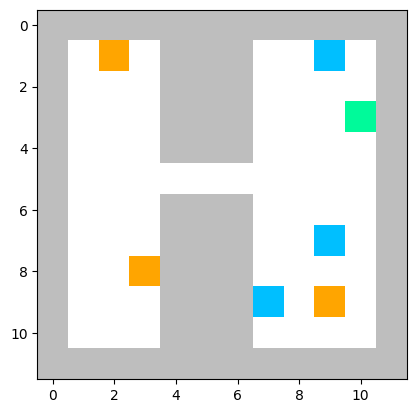

2024-06-18 19:04:22,872 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 19:04:26,630 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current location coordinates (10,8), which is also my destination, I have already reached my goal. Therefore, I don't need to move anymore.

Final Answer: Stay.

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 19:04:34,020 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on my current position, I can see that there is a wall to the north and open paths to the east, west, and south. Considering my goal is to reach the coordinates (2,10) and I'm currently at (9,10), I need to move west. However, looking at the list of visited coordinates, it's clear that I've been hovering around the same area. This suggests I might be in a dead end. Nevertheless, since I have not explored the west thoroughly yet, I should take that path. 

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 19:04:38,523 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on my current position and the directions that are not blocked, moving North would bring me closer to my destination. The destination is at (3,3) and moving North decreases the y-coordinate, which brings me closer to the destination.

Final Answer: North.

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since the destination is south of the current position, and there is an unobstructed path to the south, I should move in that direction. 

Final Answer: South

> Finished chain.


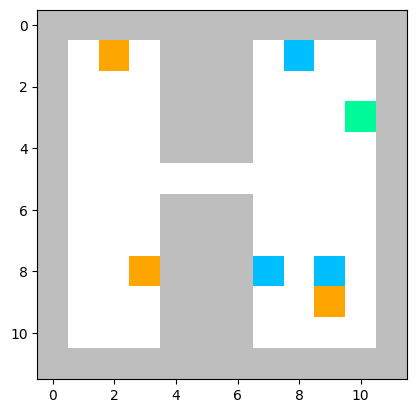

2024-06-18 19:04:42,390 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 19:04:45,598 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given that my current coordinates (10,8) are the same as my destination coordinates (10,8), it means that I have already reached my destination. Therefore, there is no need for me to move in any direction.

Final Answer: Stay

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 19:04:51,678 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Looking at the current position (8,10) and the destination (2,10), it's clear that I need to move westward along the y-axis. However, considering the coordinates I've already visited and looking at the field of view, it appears I've been stuck in a loop. A new strategy is required to avoid revisiting the same coordinates. Therefore, I should go south first to escape the loop, then move westward.

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 19:04:59,094 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on my current coordinates (7,3), my goal is to reach the destination at (3,3). Looking at the map, my west is blocked by a wall and I cannot go in that direction. I came from the south, so moving south again would lead me back to coordinates I've already visited. To the north and east lies a path. As the destination (3,3) is to the west of my current location, moving east would take me further away from the destination. So, the best choice for me would be to go north, which does not take me further from the destination and avoids revisiting coordinates.

Final Answer: North.

> Finished chain.


> Entering new CrewAgentExecutor chain...
Looking at the coordinates, I can see that my destination is directly to the south of my current position. The field of view shows that there are no obstructions on any side, so I can freely move towards my destination. 

Final Answer: South

> Finished chain.


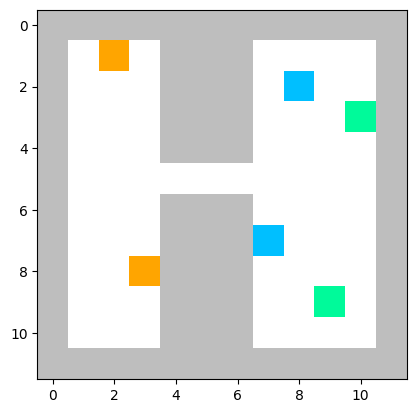

2024-06-18 19:05:03,599 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 19:05:06,697 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on my current position, the destination and the obstructions around me, I'm already at my destination. Therefore, the most logical action would be to stay.

Final Answer: Stay

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 19:05:15,281 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Looking at the coordinates I've visited, I seem to be in a loop. I need to break free from this loop and explore other parts of the map. Given my current position at (8,9) and my destination at (2,10), I should ideally move west. However, if the path west leads to a dead end or back into the loop, it would be wise to try another direction. I should take into account the layout of the map, which consists of two rooms with a passageway in the middle. I should look for this passageway using my vision and move accordingly.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 19:05:21,127 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Looking at the map and my current position, I can see that moving West is not an option as it is blocked by a wall. My destination is (3,3) which is to the South-West from my current position (7,4). However, I can only move in one direction at a time and considering I have already visited (7,3), I should try a new path.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since my current coordinates are the same as my destination, I have already arrived at my goal. 

Final Answer: Stay

> Finished chain.


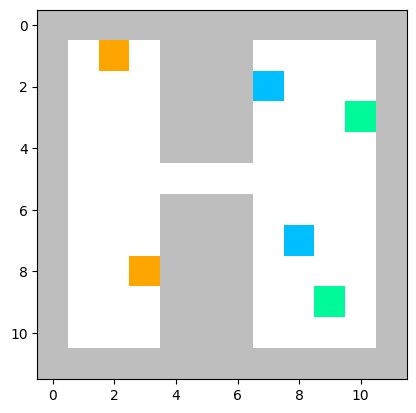

2024-06-18 19:05:23,761 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 19:05:27,145 - 26664 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering the current position and the destination coordinates are the same (10,8), it indicates that I have already reached the destination. Therefore, the best course of action is to stay where I am.

Final Answer: Stay

> Finished chain.


> Entering new CrewAgentExecutor chain...


KeyboardInterrupt: 

In [6]:
# 20 turn
for n in range(50):

  for i in range(num_agents):
     x_coordinate = env.observe()[1][i][1]
     y_coordinate = map_width-env.observe()[1][i][0]
     coordinate_list[i].append([x_coordinate, y_coordinate])

  step = [0 for i in range(num_agents)]

  #각 에이전트들의 시야에 있는 자신과 다른 에이전트들
  FOV_agents = []
  for i in range(num_agents):
    if np.any(env.observe()[0][i][0][2:7, 2:7]):
      non_zero_elements = env.observe()[0][i][0][2:7, 2:7][env.observe()[0][i][0][2:7, 2:7] != 0].tolist()
      non_zero_elements = [element - 1 for element in non_zero_elements]
      non_zero_elements.append(i)
      FOV_agents.append(non_zero_elements)

  #알고리즘을 이용해 연결된 집합 찾기
  connected_sets = merge_sets(FOV_agents)

  #연결이 있는 모든 에이전트들
  deadlocked_agents = [item for sublist in connected_sets for item in sublist]

  for i in range(num_agents):

    #교착상태에 빠지지 않은 에이전트는 독립적으로 navigate
    if i not in deadlocked_agents:
      
      a_obs = env.observe()[0][i][1]
      x = env.observe()[1][i][1]
      y = map_width-env.observe()[1][i][0]
      x_finish = toy[2][i][1]
      y_finish = map_width-toy[2][i][0]

      if a_obs[4][3] == 0:
        west = """To your west lies a path."""
      else:
        west = """Your west is blocked by a wall."""

      if a_obs[4][5] == 0:
        east = """To your east lies a path."""
      else:
        east = """Your east is blocked by a wall."""

      if a_obs[5][4] == 0:
        south = """To your south lies a path."""
      else:
        south = """Your south is blocked by a wall."""

      if a_obs[3][4] == 0:
        north = """To your north lies a path."""
      else:
        north = """Your north is blocked by a wall."""

      if len(action_list[i]) == 0:
        last_action = """"""
      elif action_list[i][-1] in ['West', 'West.']:
        last_action = f"""You came from east."""
      elif action_list[i][-1] in ['East', 'East.']:
        last_action = f"""You came from west."""
      elif action_list[i][-1] in ['South', 'South.']:
        last_action = f"""You came from north."""
      elif action_list[i][-1] in ['North', 'North.']:
        last_action = f"""You came from south."""
      elif action_list[i][-1] in ['Stay', 'Stay.']:
        last_action = f"""You paused once for another agent or you reached your goal."""
      else:
        last_action = """"""

      coordinates = f"""{coordinate_list[i]}"""

      agent_FOV = '\n'.join(' '.join(map(str, row)) for row in env.observe()[0][i][1][2:7, 2:7])

      navigation = tasks.path_finding(agents_set[i], x, y, x_finish, y_finish, east, west, north, south, last_action, coordinates, agent_FOV)

      crew = Crew(
        agents=[agents_set[i]],
        tasks=[navigation],
        verbose=0,
      )

      result = crew.kickoff()

      action_list[i].append(result)
    
      step[i] = directiondict[result]
  
  # 교착상태에 빠진 에이전트에 대해
  for connected_set in connected_sets:
    
    results = []

    for i in connected_set: # 여기서 i는 agent의 번호들
    
    #각각의 에이전트에 대해 원래 계획된 경로를 계산

      a_obs = env.observe()[0][i][1]
      x = env.observe()[1][i][1]
      y = map_width-env.observe()[1][i][0]
      x_finish = toy[2][i][1]
      y_finish = map_width-toy[2][i][0]

      if a_obs[4][3] == 0:
        west = """To your west lies a path."""
      else:
        west = """Your west is blocked by a wall."""

      if a_obs[4][5] == 0:
        east = """To your east lies a path."""
      else:
        east = """Your east is blocked by a wall."""

      if a_obs[5][4] == 0:
        south = """To your south lies a path."""
      else:
        south = """Your south is blocked by a wall."""

      if a_obs[3][4] == 0:
        north = """To your north lies a path."""
      else:
        north = """Your north is blocked by a wall."""

      if len(action_list[i]) == 0:
        last_action = """"""
      elif action_list[i][-1] in ['West', 'West.']:
        last_action = f"""You came from east."""
      elif action_list[i][-1] in ['East', 'East.']:
        last_action = f"""You came from west."""
      elif action_list[i][-1] in ['South', 'South.']:
        last_action = f"""You came from north."""
      elif action_list[i][-1] in ['North', 'North.']:
        last_action = f"""You came from south."""
      elif action_list[i][-1] in ['Stay', 'Stay.']:
        last_action = f"""You paused once for another agent or you reached your goal."""
      else:
        last_action = """"""

      coordinates = f"""{coordinate_list[i]}"""

      agent_FOV = '\n'.join(' '.join(map(str, row)) for row in env.observe()[0][i][1][2:7, 2:7])

      navigation = tasks.path_finding(agents_set[i], x, y, x_finish, y_finish, east, west, north, south, last_action, coordinates, agent_FOV)

      crew = Crew(
        agents=[agents_set[i]],
        tasks=[navigation],
        verbose=0,
      )

      result = crew.kickoff()

      results.append(result)

    env_copy = copy.deepcopy(env)
    planned_step = [0 for _ in range(num_agents)]
    for idx, agent_idx in enumerate(connected_set):
      planned_step[agent_idx] = directiondict[results[idx]]
    if -0.5 in env_copy.step(planned_step)[1]:
      collision = True
    else:
      collision = False

    if not collision:
      for idx, agent_idx in enumerate(connected_set):
        action_list[agent_idx].append(results[idx])
        step[agent_idx] = directiondict[results[idx]]
# 충돌한다면 가장 큰 넘버의 에이전트가 우선권을 가지고, 나머지는 그를 피해가야 함 (이 부분을 좀더 정교화할 필요가 있음, 특히 3명 이상의 에이전트에 대한 경우. 일단 기본적으로는 얽힌 모든 에이전트가 가장 번호가 높은 에이전트에게서 도망가게.)
# 특히, 먼저 도착한 에이전트는 장애물이 되어 그 멈춘 에이전트를 발견한 다른 에이전트의 heuristic map이 업데이트되어야 함 (멈춘 에이전트로 인해 예상치 못한 deadend가 생김)
    else:
    # 먼저 prior agent는 원래대로 이동하게 함
      prior_agent_number = max(connected_set)
      prior_agent_idx = connected_set.index(prior_agent_number)
      action_list[prior_agent_number].append(results[prior_agent_idx])
      step[prior_agent_number] = directiondict[results[prior_agent_idx]]
      for i in connected_set:
        if i != prior_agent_number:
            a_obs = env.observe()[0][i][1]
            x = env.observe()[1][i][1]
            y = map_width-env.observe()[1][i][0]
            x_finish = toy[2][i][1]
            y_finish = map_width-toy[2][i][0]

            if a_obs[4][3] == 0:
                west = """To your west lies a path."""
            else:
                west = """Your west is blocked by a wall."""

            if a_obs[4][5] == 0:
                east = """To your east lies a path."""
            else:
                east = """Your east is blocked by a wall."""

            if a_obs[5][4] == 0:
                south = """To your south lies a path."""
            else:
                south = """Your south is blocked by a wall."""

            if a_obs[3][4] == 0:
                north = """To your north lies a path."""
            else:
                north = """Your north is blocked by a wall."""

            # prior agent의 direction 구하기
            agent_map = env.observe()[0][i][0][2:7, 2:7]
            center = (2, 2)
            max_position = np.unravel_index(np.argmax(agent_map), agent_map.shape)

            row_diff = center[0] - max_position[0]
            col_diff = center[1] - max_position[1]

            if row_diff > 0 and col_diff > 0:
                direction = "northwest"
            elif row_diff > 0 and col_diff == 0:
                direction = "north"
            elif row_diff > 0 and col_diff < 0:
                direction = "northeast"
            elif row_diff == 0 and col_diff > 0:
                direction = "west"
            elif row_diff == 0 and col_diff < 0:
                direction = "east"
            elif row_diff < 0 and col_diff > 0:
                direction = "southwest"
            elif row_diff < 0 and col_diff == 0:
                direction = "south"
            elif row_diff < 0 and col_diff < 0:
                direction = "southeast"
            else:
                direction = "center"

            give_way = tasks.give_way(agents_set[i], east, west, north, south, direction)

            crew = Crew(
                agents=[agents_set[i]],
                tasks=[give_way],
                verbose=0,
            )

            result = crew.kickoff()

            action_list[i] = []
    
            step[i] = directiondict[result]


  env.step(step)
  env.render()